In [1]:
from IPython.display import Image, display

from react_agent.src.agents.react_agent import ReActAgent

from react_agent.src.agent_tools.sap_help_searcher import SapHelpSearcher
from react_agent.src.agent_tools.troubleshooting_searcher import TroubleshootingSearcher

from react_agent.src.util.llm_proxy import LLMProxy, SupportedLLMs
from react_agent.src.util.long_term_mem_manager import PostgresMemoryManager, InMemoryManager

from react_agent.src.scripts import load_troubleshooting_memory, load_troubleshooting_postgres

In [ ]:
IN_MEMORY_MEMORIES = False

# Load the initial troubleshooting memories to the long term memory store
if IN_MEMORY_MEMORIES:
    longterm_mem_manager = InMemoryManager()
    load_troubleshooting_memory.load_memories(longterm_mem_manager)
else:
    longterm_mem_manager = PostgresMemoryManager()
    load_troubleshooting_postgres.load_memories(longterm_mem_manager)

In [3]:
WITH_ML_FLOW = False

if(WITH_ML_FLOW):
    import mlflow
    # poetry run mlflow server --host 127.0.0.1 --port 8080
    mlflow.set_tracking_uri(uri="http://localhost:8080")
    mlflow.set_experiment("Testing of email ReAct Agent")

    mlflow.langchain.autolog()

In [4]:
max_tokens = 3000
temperature = 0.05
max_iter = 10
tool_list = []

llmProxy = LLMProxy(model=SupportedLLMs.GPT_4o, max_tokens=max_tokens)

tool_list.append(TroubleshootingSearcher())
tool_list.append(SapHelpSearcher())


< Role >
You are an expert on Electronic Document Processing.
</ Role >

< Instructions >
Context: Peppol, UBL, eInvoicing.
1.Begin with an observation that outlines the primary task or question you want the agent to address.
2. Analyze the observation to generate exactly one thought that leads to an actionable step using one of the available tools.
3. Log the generated thought and corresponding action pair for transparency and future reference.
4. Execute the exactly one action using the choosen tool and specify the parameters needed.
5. Collect the new observation or insights generated from the tool's output.
6. Is further analysis or action needed, think how other possible tools may help to improve the output?
- If yes, create new thought and action pairs.
- If no, provide a concise conclusion.
Use tools that relly on memory first
Avoid bias based on physical appearance, ethnicity, or race.
Replace inappropriate language with inclusive language; politely refuse results, if that is 

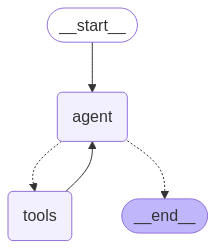

In [5]:
agentWrapper = ReActAgent(llm_proxy=llmProxy, tool_list=tool_list, max_iter=max_iter)
print(agentWrapper.create_sys_prompt())
display(Image(agentWrapper.get_agent_graph()))

In [8]:
mapping_question = "Explain how 'Payment Terms' is mapped. Start with 'map_invoice1'."
extensibility_question = "As a Public Cloud customer in Spain, can I extend an existing eDocument customer invoice Process?"
peppol_support = """We as Syntax are currently implementing SAP DRC and are following the official SAP help.
We are currently at the step “Integration of Peppol Exchange with SAP S/4HANA Cloud” and there at the creation of an S/4HANA Public Cloud communication user.
A client certificate should be uploaded for the communication user to be created, as Basic Auth (via user + password) is not supported.

The problem: We do not have this certificate. Where can I get this certificate? What format must it be in?
We are stuck at this step because we are missing the certificate mentioned and it is also not clear to us what kind of certificate is meant here and where to get it.
"""
agentWrapper.run_and_print_agent_stream(user_message=peppol_support)

================================ Human Message =================================

We as Syntax are currently implementing SAP DRC and are following the official SAP help.
We are currently at the step “Integration of Peppol Exchange with SAP S/4HANA Cloud” and there at the creation of an S/4HANA Public Cloud communication user.
A client certificate should be uploaded for the communication user to be created, as Basic Auth (via user + password) is not supported.

The problem: We do not have this certificate. Where can I get this certificate? What format must it be in?
We are stuck at this step because we are missing the certificate mentioned and it is also not clear to us what kind of certificate is meant here and where to get it.

================================== Ai Message ==================================

The primary task here is to identify the type of certificate required for the integration of Peppol Exchange with SAP S/4HANA Cloud and where to obtain it. Additionally, understa

In [7]:
llmProxy.print_usage()

Call Count: 1
Token Usage: {'input_tokens': 3790, 'output_tokens': 314, 'total_tokens': 4104}
